# Notebook 1: Data Exploration - LandCover.ai Dataset

This notebook downloads the LandCover.ai dataset, explores its structure, and demonstrates partial label simulation.

## Overview:

- **Dataset**: LandCover.ai (5 classes: background, buildings, woodlands, water, roads)
- **Task**: Semantic segmentation with partial supervision
- **Approach**: Simulate partial labels by randomly masking pixels (ignore_index = -1)


In [1]:
import sys
sys.path.append('..')

In [2]:


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from src import download_landcover_dataset, split_dataset_into_patches, set_seed, mask_to_rgb, mask_labels_random

set_seed(42)

Random seed set to 42


## 1. Dataset Download and Setup (via Kaggle Python API)

LandCover.ai is a dataset for automatic mapping of buildings, woodlands, roads, and water from aerial imagery of Poland.

**Dataset facts (summary):**

- **Tiles**: 41 orthophotos (covering ~216 km²), RGB, 25–50 cm/px
- **Classes**: background, buildings, woodlands, roads, water
- **Format**: TIFF/PNG images with matching masks (GeoTIFF in original)
- **Source**: Kaggle dataset `adrianboguszewski/landcoverai`

We'll programmatically download and unzip the dataset into `../data/` using the Kaggle Python API, then split the large tiles into 512×512 patches for efficient training.


In [3]:
project_root = Path('..').resolve()
data_dir = download_landcover_dataset(data_dir=project_root / 'data')

print(f"\n✓ Dataset ready at: {data_dir}")

✓ Dataset already exists: 41 images, 41 masks
  Location: E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data

✓ Dataset ready at: E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data


In [4]:

print("splitting large images into patches...")
split_dataset_into_patches(data_dir, target_size=512, force=False)
print("="*60)

splitting large images into patches...
✓ Patches already exist: 10674 images, 10674 masks
  Location: E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data\patches
✓ Patches already exist: 10674 images, 10674 masks
  Location: E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data\patches


In [5]:
import re


def natural_sort_key(path):
    parts = re.split(r'(\d+)', str(path.name))
    return [int(part) if part.isdigit() else part for part in parts]


patches_dir = data_dir / 'patches'

patch_images = sorted(list(patches_dir.glob('*.jpg')), key=natural_sort_key)
patch_masks = sorted(list(patches_dir.glob('*_m.png')), key=natural_sort_key)

print(f"\nFound {len(patch_images)} patch images in {patches_dir}")
print(f"Found {len(patch_masks)} patch masks in {patches_dir}")

if len(patch_images) == 0 or len(patch_masks) == 0:
    print("\nWARNING: No patches found. Please check splitting process.")
else:
    print("\nPatches ready for use!")

print(f"\nVerifying image-mask pairing (first 5):")
for i in range(min(5, len(patch_images))):
    img_base = patch_images[i].stem
    mask_base = patch_masks[i].stem.replace('_m', '')
    match = "✓" if img_base == mask_base else "✗ MISMATCH"
    print(f"  {i}: {img_base} ↔ {mask_base.replace(img_base, '...')}_m  {match}")


Found 10674 patch images in E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data\patches
Found 10674 patch masks in E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data\patches

Patches ready for use!

Verifying image-mask pairing (first 5):
  0: M-33-7-A-d-2-3_0 ↔ ..._m  ✓
  1: M-33-7-A-d-2-3_1 ↔ ..._m  ✓
  2: M-33-7-A-d-2-3_2 ↔ ..._m  ✓
  3: M-33-7-A-d-2-3_3 ↔ ..._m  ✓
  4: M-33-7-A-d-2-3_4 ↔ ..._m  ✓


In [6]:
from collections import Counter

label_counter = Counter()
max_masks_to_scan = min(10, len(patch_masks))

for mpath in patch_masks[:max_masks_to_scan]:
    m = np.array(Image.open(mpath))
    if m.ndim == 3:
        m = m[:, :, 0]
    vals, counts = np.unique(m, return_counts=True)
    label_counter.update(dict(zip(vals.tolist(), counts.tolist())))

if label_counter:
    unique_labels = sorted(label_counter.keys())
    total_pixels = sum(label_counter.values())
    print(
        f"Unique label ids (first {max_masks_to_scan} patches): {unique_labels}")
    for k in unique_labels:
        pct = 100 * label_counter[k] / total_pixels
        print(f"  Class {k}: {label_counter[k]:,} pixels ({pct:.2f}%)")
else:
    print("No masks found to inspect.")

class_names = ['background', 'buildings', 'woodlands', 'water', 'roads']
print("\nClass mapping:")
for i, name in enumerate(class_names):
    print(f"  {i} → {name}")

Unique label ids (first 10 patches): [0, 2, 4]
  Class 0: 36,684 pixels (1.40%)
  Class 2: 2,522,306 pixels (96.22%)
  Class 4: 62,450 pixels (2.38%)

Class mapping:
  0 → background
  1 → buildings
  2 → woodlands
  3 → water
  4 → roads


## 2. Sample Visualization

Let's visualize some sample images with their ground truth masks to understand the dataset.


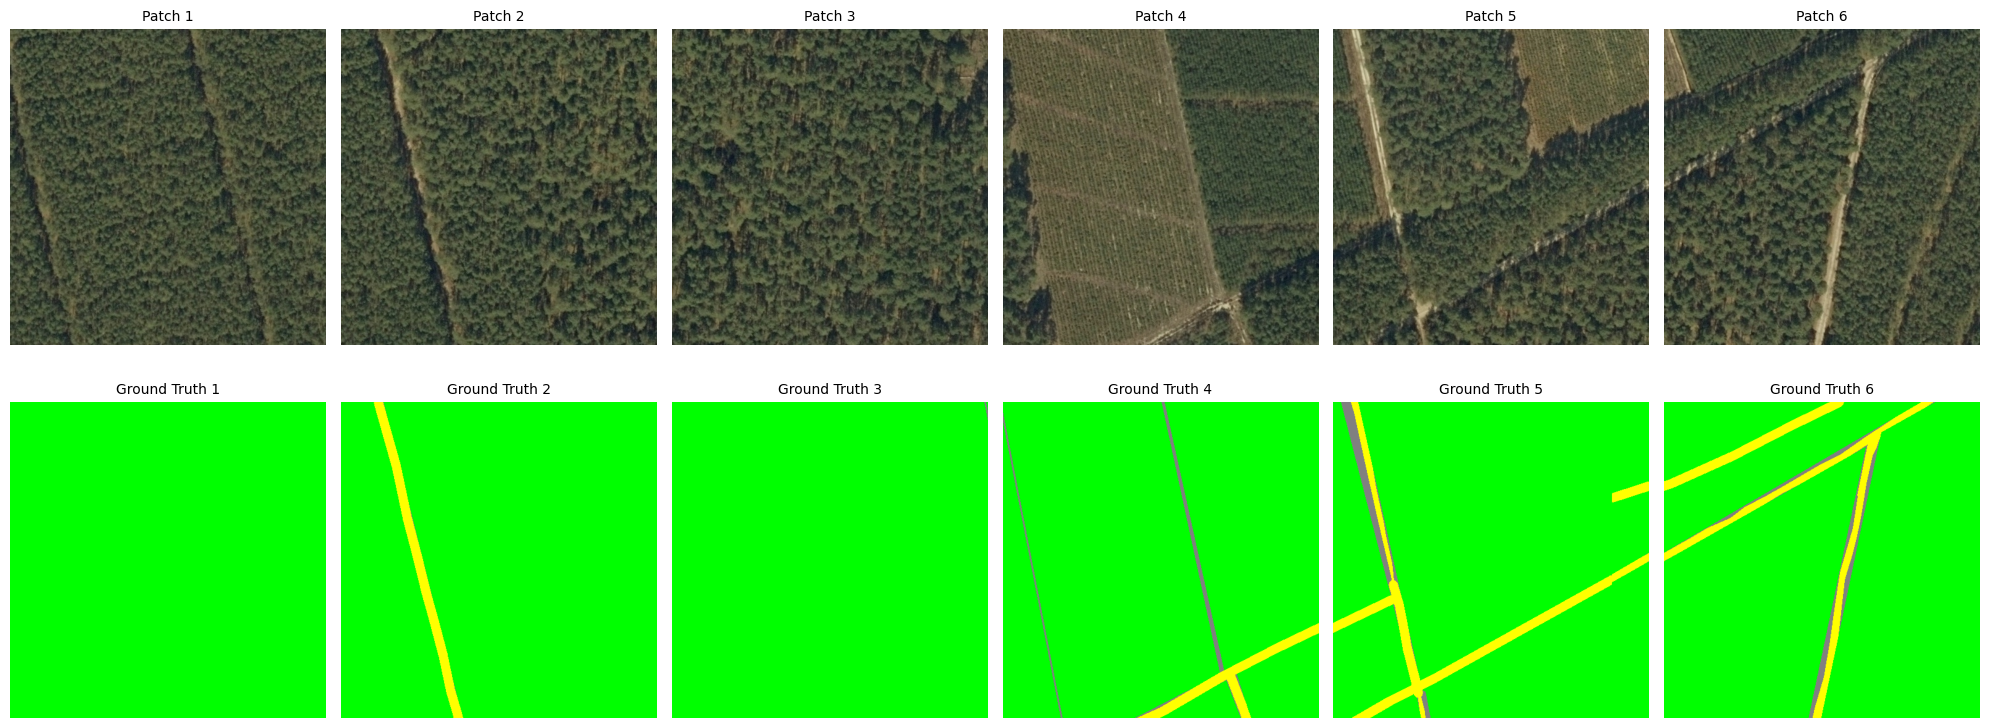

✓ Sample visualization complete


In [7]:
if len(patch_images) > 0:
    num_samples = min(6, len(patch_images))
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    for i in range(num_samples):
        image = np.array(Image.open(patch_images[i]).convert('RGB'))
        mask = np.array(Image.open(patch_masks[i]))

        if len(mask.shape) == 3:
            mask = mask[:, :, 0]

        axes[0, i].imshow(image)
        axes[0, i].set_title(f'Patch {i+1}', fontsize=10)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask_to_rgb(mask))
        axes[1, i].set_title(f'Ground Truth {i+1}', fontsize=10)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(data_dir / 'sample_visualization.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Sample visualization complete")
else:
    print("Skipping visualization - no patches found")

## 3. Partial Label Simulation

Now we'll demonstrate creating partial labels by randomly masking pixels at different rates.


100% target: 262144/262144 = 100.0% actual
70% target: 183500/262144 = 70.0% actual
50% target: 131072/262144 = 50.0% actual
30% target: 78643/262144 = 30.0% actual


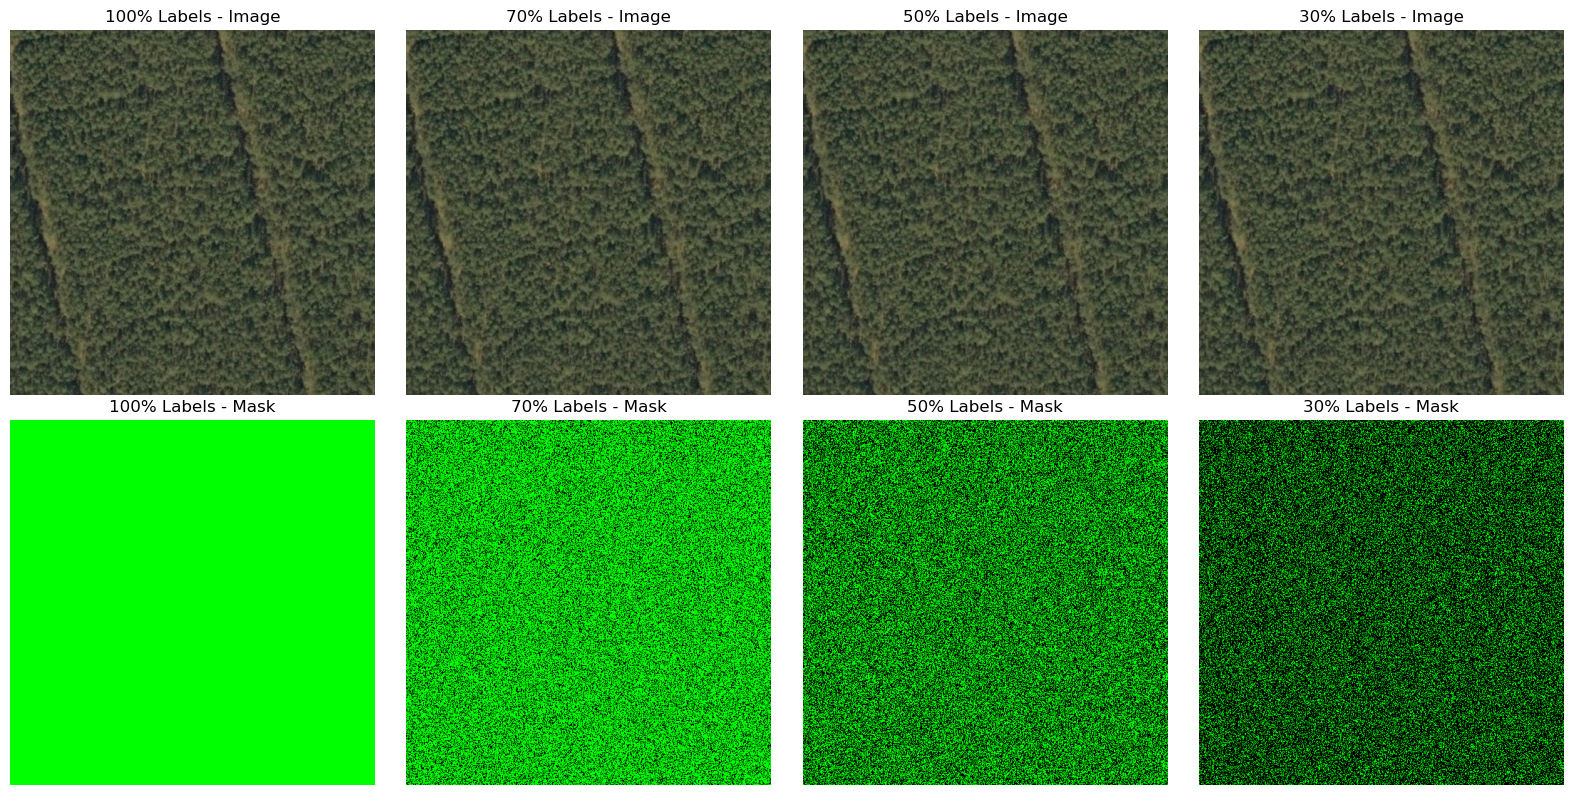


✓ Partial label simulation complete
  Black pixels = unlabeled (ignore_index = -1)
  Colored pixels = labeled (available for training)


In [10]:
if len(patch_images) > 0:
    test_image = np.array(Image.open(patch_images[0]).convert('RGB'))
    test_mask = np.array(Image.open(patch_masks[0]))

    if len(test_mask.shape) == 3:
        test_mask = test_mask[:, :, 0]

    label_fractions = [1.0, 0.7, 0.5, 0.3]
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for i, frac in enumerate(label_fractions):
        if frac < 1.0:
            partial_mask = mask_labels_random(test_mask, frac, seed=42)
        else:
            partial_mask = test_mask.copy()

        axes[0, i].imshow(test_image)
        axes[0, i].set_title(f'{int(frac*100)}% Labels - Image', fontsize=12)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask_to_rgb(partial_mask, ignore_index=-1))
        axes[1, i].set_title(f'{int(frac*100)}% Labels - Mask', fontsize=12)
        axes[1, i].axis('off')

        labeled_pixels = (partial_mask != -1).sum()
        total_pixels = partial_mask.size
        print(f"{int(frac*100)}% target: {labeled_pixels}/{total_pixels} = {labeled_pixels/total_pixels:.1%} actual")

    plt.tight_layout()
    plt.savefig(data_dir / 'partial_labels_demo.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Partial label simulation complete")
    print("  Black pixels = unlabeled (ignore_index = -1)")
    print("  Colored pixels = labeled (available for training)")
else:
    print("Skipping partial label demo - no patches found")

## 4. Save Sample Data for Testing

Save a few samples for quick testing in later notebooks.


In [11]:
sample_dir = data_dir / 'samples'
sample_dir.mkdir(exist_ok=True)

if len(patch_images) > 0:
    num_save = min(3, len(patch_images))

    for i in range(num_save):
        image = Image.open(patch_images[i])
        mask = Image.open(patch_masks[i])

        image.save(sample_dir / f'sample_image_{i}.png')
        mask.save(sample_dir / f'sample_mask_{i}.png')

    print(f"✓ Saved {num_save} sample pairs to {sample_dir}")
else:
    print("No samples to save")

print("\n" + "="*60)
print("NOTEBOOK 1 COMPLETE")
print("="*60)
print("\nSummary:")
print(f"  - Dataset directory: {data_dir}")
print(f"  - Patches found: {len(patch_images)}")
print(f"  - Samples saved: {sample_dir}")
print("\nNext step: Run Notebook 2 (02_core_implementation.ipynb)")

✓ Saved 3 sample pairs to E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data\samples

NOTEBOOK 1 COMPLETE

Summary:
  - Dataset directory: E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data
  - Patches found: 10674
  - Samples saved: E:\Work\FreeL\LinkedIn\Meriti\deep learning task\data\samples

Next step: Run Notebook 2 (02_core_implementation.ipynb)
